In [1]:
from doctest import testsource

import pandas as pd
import numpy as np
import random, copy
import torch
import torch.nn as nn
from torch import no_grad
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, \
    pipeline
from torch.optim import AdamW
from sklearn.metrics import f1_score
from sklearn.utils import resample
import nltk
from nltk.corpus import wordnet, stopwords
from transformers import logging
import matplotlib.pyplot as plt
import os

logging.set_verbosity_error()

# Download NLTK data (WordNet for synonyms, stopwords list)
nltk.download('wordnet')
nltk.download('stopwords')
# Data augmentation: Synonym Replacement
stop_words = set(stopwords.words('english'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yiqin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yiqin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load and explore the dataset
We load the data and analyze the distribution of labels, paragraph lengths, and label distributions per keyword and country. We also examine some examples of patronizing paragraphs, especially those with label 4 (highly patronizing).

In [2]:
df = pd.read_csv('./data/dontpatronizeme_pcl.tsv', sep='\t', header=None,
                 names=["par_id", "art_id", "keyword", "country", "paragraph", "orig_label"], skiprows=4)
df['label'] = df['orig_label'].apply(lambda x: 1 if x >= 2 else 0)

df.info

<bound method DataFrame.info of        par_id      art_id     keyword country  \
0           1  @@24942188    hopeless      ph   
1           2  @@21968160     migrant      gh   
2           3  @@16584954   immigrant      ie   
3           4   @@7811231    disabled      nz   
4           5   @@1494111     refugee      ca   
...       ...         ...         ...     ...   
10464   10465  @@14297363       women      lk   
10465   10466  @@70091353  vulnerable      ph   
10466   10467  @@20282330     in-need      ng   
10467   10468  @@16753236    hopeless      in   
10468   10469  @@16779383    homeless      ie   

                                               paragraph  orig_label  label  
0      We 're living in times of absolute insanity , ...           0      0  
1      In Libya today , there are countless number of...           0      0  
2      White House press secretary Sean Spicer said t...           0      0  
3      Council customers only signs would be displaye...           

orig_label
0    8529
1     947
2     144
3     458
4     391
Name: count, dtype: int64


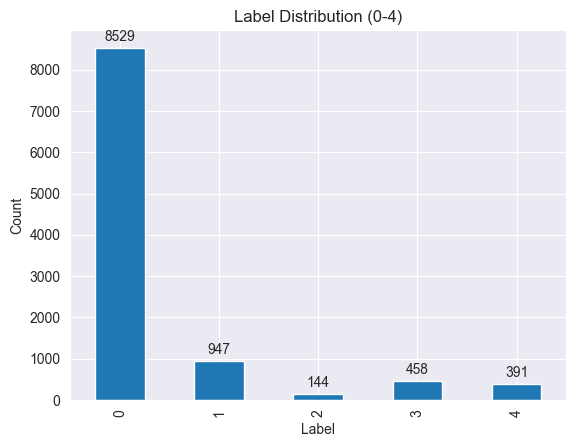

Binary distribution:
 label
0    9476
1     993
Name: count, dtype: int64


In [3]:

# Distribution of original 5 labels (0–4)
label_counts = df["orig_label"].value_counts().sort_index()
print(label_counts)

# Plot distribution
fig, ax = plt.subplots()
label_counts.plot(kind="bar", ax=ax, title="Label Distribution (0-4)")
ax.set_xlabel("Label")
ax.set_ylabel("Count")

for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        xy=(p.get_x() + p.get_width() / 2., p.get_height()),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom'
    )

plt.show()

# Convert to binary (0,1), i.e. labels >=2 are PCL
binary_counts = df["label"].value_counts()
print("Binary distribution:\n", binary_counts)

Average paragraph length by label:
 orig_label
0    47.418103
1    52.019007
2    49.104167
3    51.556769
4    57.700767
Name: para_length, dtype: float64


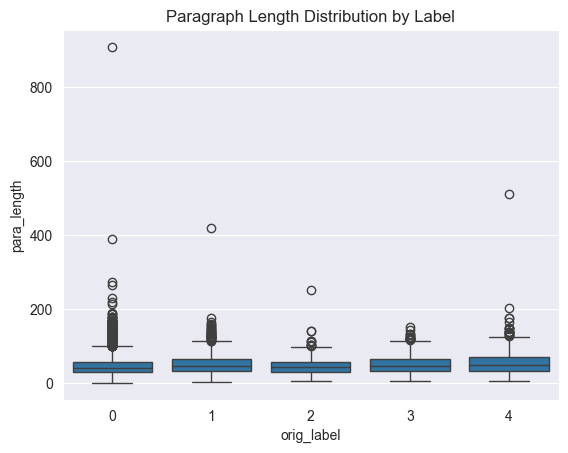

In [4]:
df["str_paragraph"] = df["paragraph"].astype(str).fillna("")


df["para_length"] = df["str_paragraph"].apply(lambda x: len(x.split()))
# Group by label, compute mean or median paragraph length
length_by_label = df.groupby("orig_label")["para_length"].mean()
print("Average paragraph length by label:\n", length_by_label)

import seaborn as sns

sns.boxplot(x="orig_label", y="para_length", data=df)
plt.title("Paragraph Length Distribution by Label")
plt.show()

# # Plot length distributions
# fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# length_by_label.plot(kind="bar", ax=ax, title="Paragraph Length Distribution by Label")
# ax.set_xlabel("Label")
# ax.set_ylabel("Paragraph Length")
#
# for p in ax.patches:
#     ax.annotate(
#         str(int(p.get_height())),
#         xy=(p.get_x() + p.get_width() / 2., p.get_height()),
#         xytext=(0, 3),
#         textcoords="offset points",
#         ha='center', va='bottom'
#     )
#
# plt.show()


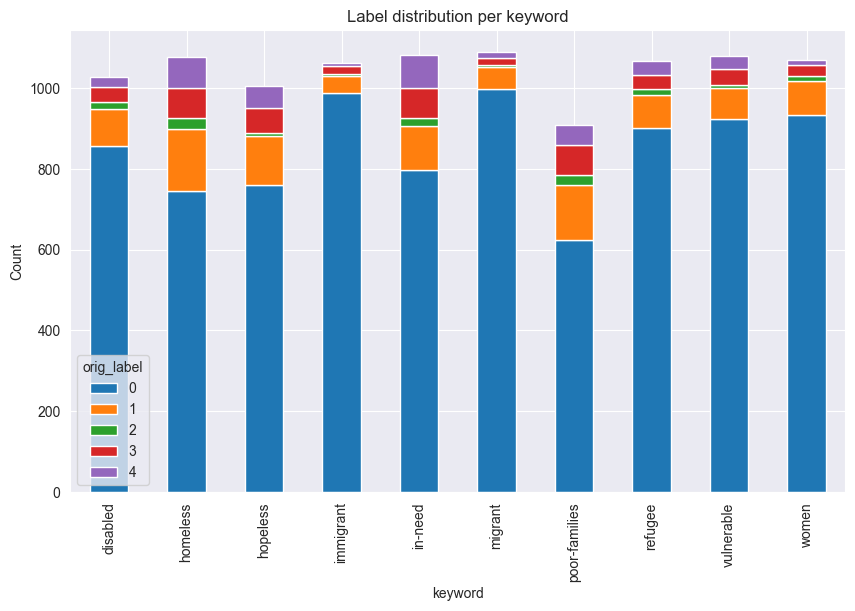

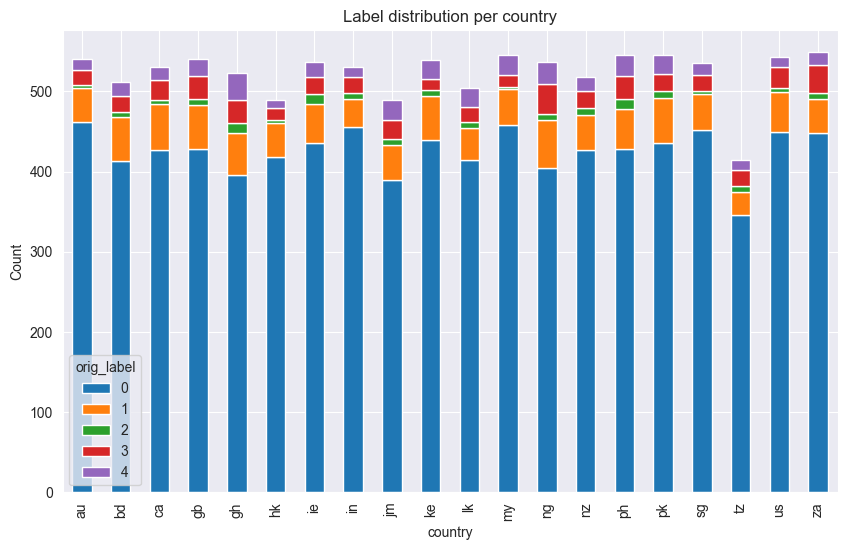

In [5]:
pd.crosstab(df["keyword"], df["orig_label"]).plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Label distribution per keyword")
plt.ylabel("Count")
plt.show()

pd.crosstab(df["country"], df["orig_label"]).plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Label distribution per country")
plt.ylabel("Count")
plt.show()

In [6]:
import random

for lbl in [0,1,2,3,4]:
    subset = df[df["orig_label"] == lbl]
    example = subset.sample(1, random_state=10)
    print(f"\nLabel {lbl} example:")
    print(example["paragraph"].values[0], "\n")

# Note: The data was annotated by multiple annotators (leading to 0–4 labels). Observing paragraphs with label=1 or label=2 often reveals partial disagreements or borderline cases.
# Examine paragraphs that were assigned label 4 (highly patronizing). Are they obviously condescending or do they also have borderline tones?



Label 0 example:
It was time and again mentioned that Pakistan Squash Federation ( PSF ) must wake up from deep slump and pay proper attention towards women squash , but no heed was paid and the result is evident that except Canadian-based Pakistani Maria , all women squash players were thrown out of the event . The PSF must start work on female squash promotion on war footings , or else just ask females to forget about playing international squash . 


Label 1 example:
The first time MP , who is a holder of Bachelor in Medicine and Bachelor in Surgery from the University of Nairobi , has in the past decried how women often shun disabled man . He is also on record for paying tribute to his wife , a nurse , for taking care of him all though . 


Label 2 example:
" A mass protest was held in Jaffna at 3 p.m. yesterday against Tamil Nadu politicians Thol . Thiruvmavalavan , T. Velmurugan and Y. Gopalaswamy , who prevented the superstar of Tamil cinema , Rajinikanth , visiting Jaffna to h

The result shows that the data set is highly imbalanced, with the majority of paragraphs labeled as 0 (not patronizing) and only a small fraction labeled as 1 (patronizing). The average paragraph length is similar across labels.

### Data Augmentation and Balancing
We will augment the training data by applying two techniques: synonym replacement and back-translation. Synonym replacement replaces words in the text with synonyms, while back-translation translates the text to another language and back to the original language. These techniques can help improve model generalization and robustness.

In [7]:
# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    # Identify candidate words (non-stopwords, alphabetic only)
    candidates = [i for i, w in enumerate(words) if w.lower() not in stop_words and w.isalpha()]
    random.shuffle(candidates)
    replaced = 0
    for idx in candidates:
        if replaced >= n:
            break
        synonyms = set()
        for syn in wordnet.synsets(words[idx]):
            for lemma in syn.lemmas():
                if lemma.name().lower() != words[idx].lower():
                    synonyms.add(lemma.name().replace('_', ' '))
        if synonyms:
            new_words[idx] = random.choice(list(synonyms))
            replaced += 1
    return " ".join(new_words)

translator_en_to_es = pipeline("translation_en_to_es", model="Helsinki-NLP/opus-mt-en-es", device=-1)
translator_es_to_en = pipeline("translation_es_to_en", model="Helsinki-NLP/opus-mt-es-en", device=-1)

def back_translate(sentence):
    try:
        es_text = translator_en_to_es(sentence, max_length=MAX_LENGTH)[0]['translation_text']
        back_text = translator_es_to_en(es_text, max_length=MAX_LENGTH)[0]['translation_text']
        return back_text
    except Exception as e:
        return sentence  # fallback to original if translation fails


# Augment training data (apply to minority class samples)
def augment_data(df):
    augmented_texts = []
    augmented_labels = []
    for _, row in df[df['label'] == 1].iterrows():
        text = row['paragraph']
        # Synonym replacement augmentation
        aug_text1 = synonym_replacement(text, n=1)
        # Back-translation augmentation
        aug_text2 = back_translate(text)
        augmented_texts.extend([aug_text1, aug_text2])
        augmented_labels.extend([1, 1])
    aug_df = pd.DataFrame({'paragraph': augmented_texts, 'label': augmented_labels})
    # Combine augmented samples with original data
    return pd.concat([df, aug_df], ignore_index=True)


# Oversample minority class to balance the dataset
def oversample_data(df):
    df_majority = df[df['label'] == 0]
    df_minority = df[df['label'] == 1]
    if len(df_minority) == 0 or len(df_majority) == 0:
        return df
    if len(df_minority) < len(df_majority):
        df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=0)
        df_balanced = pd.concat([df_majority, df_minority_upsampled], ignore_index=True)
    else:
        df_majority_upsampled = resample(df_majority, replace=True, n_samples=len(df_minority), random_state=0)
        df_balanced = pd.concat([df_minority, df_majority_upsampled], ignore_index=True)
    # Shuffle after oversampling
    df_balanced = df_balanced.sample(frac=1, random_state=0).reset_index(drop=True)
    return df_balanced

In [8]:
from sklearn.model_selection import train_test_split
training_dev_df = pd.read_csv('./data/train_semeval_parids-labels.csv', sep=',', header=None,
                              names=["par_id", "values"], skiprows=1)
test_dev_df = pd.read_csv('./data/dev_semeval_parids-labels.csv', sep=',', header=None,
                          names=["par_id", "values"], skiprows=1)

train_dev_index = training_dev_df['par_id']
test_dev_index = test_dev_df['par_id']
df_indexed = df.set_index('par_id', drop=False)

# Then slice with .loc, using your dev-index lists:
train_dev_df = df_indexed.loc[train_dev_index].copy()
test_df      = df_indexed.loc[test_dev_index].copy()
train_df, val_df = train_test_split(train_dev_df, test_size=0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
# dev.txt dataset
test_df = test_df.reset_index(drop=True)
test_df.fillna("", inplace=True)

print(train_df.head())
print(train_df.info())
print(test_df.head())
print(test_df.info())

   par_id      art_id     keyword country  \
0    5423  @@20407937    disabled      nz   
1    6890  @@16028961     in-need      us   
2    1394  @@14758376  vulnerable      au   
3    4445   @@3174447  vulnerable      za   
4    7991  @@20728606    hopeless      ca   

                                           paragraph  orig_label  label  \
0  Critics have even taken to dobbing in Katrina ...           0      0   
1  Alexis and her family decided to donate more t...           0      0   
2  Mr Porter , do you think you will get the numb...           4      1   
3  " This only serves to highlight the importance...           1      0   
4  " I was nervous , but life has taught me over ...           0      0   

                                       str_paragraph  para_length  
0  Critics have even taken to dobbing in Katrina ...           31  
1  Alexis and her family decided to donate more t...           18  
2  Mr Porter , do you think you will get the numb...           43  
3  " T

In [9]:
train_df = train_df.dropna(subset=['paragraph'])
train_df['paragraph'] = train_df['paragraph'].astype(str)


# Augment and balance training data
train_df_aug = augment_data(train_df)
train_df_upsample = oversample_data(train_df)
train_df_both = oversample_data(train_df_aug)

for idx, row in train_df.iterrows():
    if not isinstance(row['paragraph'], str):
        print(f"Row {idx} has invalid type: {type(row['paragraph'])}, value = {row['paragraph']}")

train_df.to_csv("./example_training_data/train.csv", index=False)
train_df_both.to_csv("./example_training_data/train_augmented_oversampled.csv", index=False)
train_df_aug.to_csv("./example_training_data/train_augmented.csv", index=False)
train_df_upsample.to_csv("./example_training_data/train_oversampled.csv", index=False)

val_df.to_csv("./example_training_data/val.csv", index=False)
test_df.to_csv("./example_training_data/test.csv", index=False)


label
0    6073
1    6073
Name: count, dtype: int64


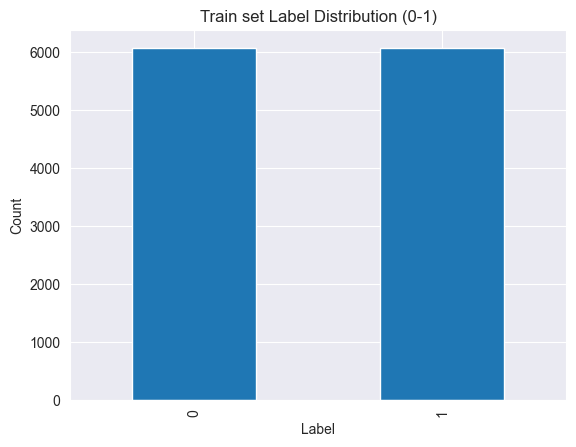

label
0    1895
1     199
Name: count, dtype: int64


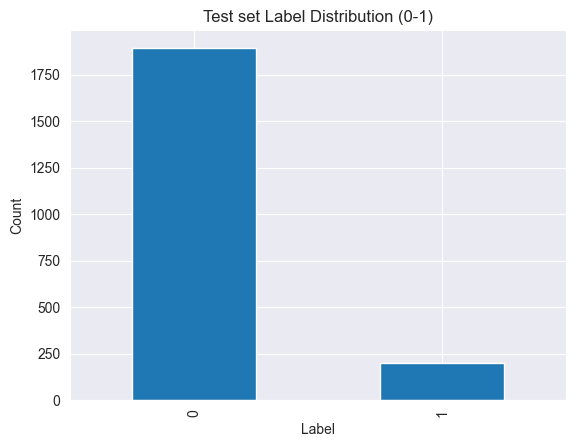

In [10]:
# Distribution of original 5 labels (0–4)
label_counts = train_df_both["label"].value_counts().sort_index()
print(label_counts)

# Plot distribution
label_counts.plot(kind="bar", title="Train set Label Distribution (0-1)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Distribution of original 5 labels (0–4)
label_counts = test_df["label"].value_counts().sort_index()
print(label_counts)

# Plot distribution
label_counts.plot(kind="bar", title="Test set Label Distribution (0-1)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Training and Evaluation



In [11]:
MODEL_NAME = 'roberta-base'
MAX_LENGTH = 256
BATCH_SIZE = 16
NUM_EPOCHS = 3
PATIENCE = [2, 3, 4]
WARMUP_PROPORTION = [0.05, 0.1, 0.2]
LR_CANDIDATES = [1e-5, 2e-5, 5e-5]
ENSEMBLE_SEEDS = [42, 52, 62]

In [12]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    set_seed,
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score
import optuna

In [13]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256):
        self.texts = df["paragraph"].tolist()
        self.labels = df["label"].tolist() if "label" in df.columns else None
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # Tokenize
        inputs = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        # Flatten tensor dims from (1, ...) to (...):
        item = {k: v.squeeze(0) for k, v in inputs.items()}

        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [17]:
from transformers import RobertaForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput

class WeightedRoberta(nn.Module):
    def __init__(self, model_name: str, num_labels: int, class_weights: torch.Tensor):
        super().__init__()
        self.base_model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )
        self.class_weights = class_weights

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        **kwargs
    ):
        # --- FIX: pop any extra kwarg(s) Trainer might pass ---
        kwargs.pop("num_items_in_batch", None)  # ignore if present

        # Optionally pop other possible stray kwargs here:
        # kwargs.pop("some_other_arg", None)

        # Now run forward without unexpected kwargs
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None,  # We'll handle the loss below
            **kwargs
        )
        logits = outputs.logits

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [18]:
train_labels = train_df['label'].values
class_weights_experiment = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_tensor_experiment = torch.tensor(class_weights_experiment, dtype=torch.float)

train_labels_aug = train_df_aug['label'].values
class_weights_final = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_aug),
    y=train_labels_aug
)
class_weights_tensor_final = torch.tensor(class_weights_final, dtype=torch.float)

print("Experiment class weights:", class_weights_tensor_experiment)
print("Final class weights:", class_weights_tensor_final)

Experiment class weights: tensor([0.5516, 5.3429])
Final class weights: tensor([0.6549, 2.1143])


In [20]:
# ---------------------------------------------
# (E) Create datasets for Trainer
# ---------------------------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset = CustomDataset(train_df_both, tokenizer, max_length=MAX_LENGTH)
val_dataset   = CustomDataset(val_df,       tokenizer, max_length=MAX_LENGTH)
test_dataset  = CustomDataset(test_df,      tokenizer, max_length=MAX_LENGTH)


# ---------------------------------------------
# (F) Define metric computation for Trainer
# ---------------------------------------------
def compute_metrics(eval_pred):
    """Compute F1 (binary) and accuracy."""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"f1": f1, "accuracy": acc}


# -----------------------------------------------------------------
# (G) Define Optuna objective function for hyperparameter search
# -----------------------------------------------------------------
def objective(trial):
    """
    Optuna objective that:
      - Picks lr, patience, warmup ratio.
      - Trains model.
      - Returns Val F1 for best epoch (Trainer handles early stopping).
    """
    lr = trial.suggest_categorical("lr", LR_CANDIDATES)
    patience = trial.suggest_categorical("patience", PATIENCE)
    warmup_ratio = trial.suggest_categorical("warmup_ratio", WARMUP_PROPORTION)

    # Create Weighted Roberta
    model = WeightedRoberta(
        model_name=MODEL_NAME,
        num_labels=2,
        class_weights=class_weights_tensor_final
    )

    # Define Trainer args
    training_args = TrainingArguments(
        output_dir=f"./optuna_trial_{trial.number}",
        do_train=True,
        do_eval=True,
        num_train_epochs=NUM_EPOCHS,
        learning_rate=lr,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        weight_decay=1e-2,  # from your custom loop
        evaluation_strategy="epoch",     # Evaluate every epoch
        save_strategy="epoch",           # Save every epoch (so we can load best)
        load_best_model_at_end=True,     # Always load best at the end
        metric_for_best_model="f1",      # Which metric to track
        greater_is_better=True,
        bf16=True,                       # Use bf16 precision (if supported)
        warmup_ratio=warmup_ratio,       # Warm-up proportion
        logging_steps=50,                # Adjust as desired
        seed=42,                         # Keep some default
    )

    # Build a Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(
            early_stopping_patience=patience,
            early_stopping_threshold=0.0
        )],
    )

    # Train
    trainer.train()

    # Evaluate
    eval_metrics = trainer.evaluate()
    val_f1 = eval_metrics["eval_f1"]

    print(f"Trial {trial.number} - LR={lr}, Patience={patience}, Warmup={warmup_ratio} => Val F1={val_f1:.4f}")

    return val_f1


# -----------------------------------------------------------------
# (H) Run an ensemble of models with different seeds
# -----------------------------------------------------------------
ensemble_models = []

for seed in ENSEMBLE_SEEDS:
    # Fix the seed for reproducibility
    set_seed(seed)

    # Create Optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)  # e.g., run 10 trials for each seed

    # Get best params
    best_lr = study.best_params["lr"]
    best_patience = study.best_params["patience"]
    best_warmup_ratio = study.best_params["warmup_ratio"]
    best_val_f1 = study.best_value

    print(f"\n[Seed {seed}] Best LR={best_lr}, Patience={best_patience}, Warmup={best_warmup_ratio}, Val F1={best_val_f1:.4f}")

    # Retrain final model on best hyperparams
    final_model = WeightedRoberta(
        model_name=MODEL_NAME,
        num_labels=2,
        class_weights=class_weights_tensor_experiment  # or class_weights_tensor_final
    )

    training_args = TrainingArguments(
        output_dir=f"./final_model_seed_{seed}",
        do_train=True,
        do_eval=True,
        num_train_epochs=NUM_EPOCHS,
        learning_rate=best_lr,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        weight_decay=1e-2,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        bf16=True,
        warmup_ratio=best_warmup_ratio,
        logging_steps=50,
        seed=seed,
    )

    final_trainer = Trainer(
        model=final_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(
            early_stopping_patience=best_patience,
            early_stopping_threshold=0.0
        )],
    )

    # Train final model
    final_trainer.train()

    # Save and keep the best model in memory
    final_trainer.save_model(f"model_seed_{seed}")
    ensemble_models.append(final_trainer.model)

    print(f"Finished training with seed={seed}, best val F1={best_val_f1:.4f}")
    print("-"*60)

[I 2025-03-01 22:11:37,460] A new study created in memory with name: no-name-7c2d7b15-7a52-4a53-9f6d-979b46b1e26f
C:\Users\yiqin\Desktop\NLP_CW\venv\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
[W 2025-03-01 22:11:46,242] Trial 0 failed with parameters: {'lr': 5e-05, 'patience': 2, 'warmup_ratio': 0.2} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\yiqin\Desktop\NLP_CW\venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\yiqin\AppData\Local\Temp\ipykernel_18268\146012956.py", line 78, in objective
    trainer.train()
  File "C:\Users\yiqin\Desktop\NLP_CW\venv\Lib\site-packages\transformers\trainer.py", line 2241, in train
    return inner_training_loop(
           ^^

KeyboardInterrupt: 

In [26]:
all_predictions = []
for model in ensemble_models:
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in test_loader:  # val_loader is a DataLoader object
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)
    all_predictions.append(preds)

# Transpose and vote
all_predictions = np.array(all_predictions)  # shape: (num_models, num_examples)
ensemble_preds = []
for j in range(all_predictions.shape[1]):
    votes = np.sum(all_predictions[:, j])
    ensemble_preds.append(1 if votes > len(ensemble_models) / 2 else 0)

# We need the original validation DataFrame for labels and paragraph IDs
test_labels = test_df['label'].values  # Use val_df, not val_loader
dev_f1 = f1_score(test_labels, ensemble_preds, average='binary')
print(f"Best Local Test F1 = {dev_f1:.4f}")

# Save predictions to files using the original DataFrames
with open("predictions_dev_test.txt", "w") as f:
    for pred in ensemble_preds:
        f.write(f"{pred}\n")

print("Prediction files generated: predictions_dev_test.txt")

Ensemble Local Test F1 = 0.6010
Prediction files generated: predictions_dev_test.txt


In [27]:
# After making your ensemble predictions:
incorrect_indices = []
incorrect_examples = []

for i, (true, pred) in enumerate(zip(test_labels, ensemble_preds)):
    if true != pred:
        incorrect_indices.append(i)
        incorrect_examples.append({
            'par_id': test_df['par_id'].iloc[i],
            'paragraph': test_df['paragraph'].iloc[i],
            'true_label': true,
            'predicted': pred
        })

# Create a DataFrame with incorrect examples
incorrect_df = pd.DataFrame(incorrect_examples)

# Save to file
incorrect_df.to_csv("incorrect_predictions.csv", index=False)

# Print summary
print(f"Found {len(incorrect_indices)} incorrect predictions out of {len(test_labels)} examples ({len(incorrect_indices)/len(test_labels)*100:.2f}%)")

# Print some examples if desired
print("\nSample incorrect predictions:")
for i, example in enumerate(incorrect_examples[:5]):  # Show first 5
    print(f"Example {i+1}:")
    print(f"ID: {example['par_id']}")
    print(f"Text: {example['paragraph'][:100]}..." if len(example['paragraph']) > 100 else example['paragraph'])
    print(f"True label: {example['true_label']}, Predicted: {example['predicted']}")
    print("-" * 50)

from sklearn.metrics import classification_report, confusion_matrix

# Print detailed metrics
print(classification_report(test_labels, ensemble_preds))

# Show confusion matrix
print(confusion_matrix(test_labels, ensemble_preds))

# Check class distribution
print(f"Class distribution in test set: {np.unique(test_labels, return_counts=True)}")

Found 81 incorrect predictions out of 1047 examples (7.74%)

Sample incorrect predictions:
Example 1:
ID: 3901
Text: " The national and county governments must work together to improve the lives of the disabled , " sa...
True label: 0, Predicted: 1
--------------------------------------------------
Example 2:
ID: 6890
Alexis and her family decided to donate more than 400 of those presents to children in need .
True label: 0, Predicted: 1
--------------------------------------------------
Example 3:
ID: 9505
Text: I mention these moments to highlight and illustrate the potential that young people have to change o...
True label: 0, Predicted: 1
--------------------------------------------------
Example 4:
ID: 2679
Text: She was speaking at Colours of Cape Town , a night of solidarity between Cape Town 's LGBTI and immi...
True label: 0, Predicted: 1
--------------------------------------------------
Example 5:
ID: 4393
Text: The law stipulated 21 rights of the disabled persons . The disa

In [33]:
final_test_without_predictions = pd.read_csv('./data/task4_test.tsv', sep='\t', header=None,
                    names=["par_id", "art_id", "keyword", "country", "paragraph"], skiprows=0)
print(final_test_without_predictions.head())
print(final_test_without_predictions.info())

final_test_without_predictions = final_test_without_predictions.dropna(subset=['paragraph'])
final_test_without_predictions['paragraph'] = final_test_without_predictions['paragraph'].astype(str)

final_test_loader = build_dataloader(final_test_without_predictions, tokenizer, batch_size=BATCH_SIZE, shuffle=False)

all_final_test_preds = []

for model in ensemble_models:
    model.eval()
    preds = []
    with torch.no_grad():
        for batch in final_test_loader:  # val_loader is a DataLoader object
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)
    all_final_test_preds.append(preds)

# Transpose and vote
all_final_test_preds = np.array(all_final_test_preds)  # shape: (num_models, num_examples)
ensemble_final_test_preds = []
for j in range(all_final_test_preds.shape[1]):
    votes = np.sum(all_final_test_preds[:, j])
    ensemble_final_test_preds.append(1 if votes > len(ensemble_models) / 2 else 0)

# Save predictions to files using the original DataFrames
with open("test.txt", "w") as f:
    for pred in ensemble_final_test_preds:
        f.write(f"{pred}\n")

  par_id      art_id     keyword country  \
0    t_0   @@7258997  vulnerable      us   
1    t_1  @@16397324       women      pk   
2    t_2  @@16257812     migrant      ca   
3    t_3   @@3509652     migrant      gb   
4    t_4    @@477506  vulnerable      ca   

                                           paragraph  
0  In the meantime , conservatives are working to...  
1  In most poor households with no education chil...  
2  The real question is not whether immigration i...  
3  In total , the country 's immigrant population...  
4  Members of the church , which is part of Ken C...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   par_id     3832 non-null   object
 1   art_id     3832 non-null   object
 2   keyword    3832 non-null   object
 3   country    3832 non-null   object
 4   paragraph  3832 non-null   object
dtypes: object(5)
memory u

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [28]:
import random
import numpy as np
import torch
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

###################################################
# REUSABLE UTILITIES (SEEDING, ETC.)
###################################################
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

###################################################
# BOW BASELINE IMPLEMENTATION
###################################################
def train_bow_baseline(train_df, val_df, seed=42):
    """
    Trains a simple Naïve Bayes Bag-of-Words baseline.

    :param train_df: A pandas DataFrame with columns ['paragraph', 'label']
    :param val_df: A pandas DataFrame with columns ['paragraph', 'label']
    :param seed: Random seed for reproducibility
    :return: A tuple (vectorizer, model) of the trained baseline
    """

    # Ensure reproducibility
    set_seed(seed)

    # Shuffle data (optional, but often good practice)
    train_df = shuffle(train_df, random_state=seed).reset_index(drop=True)
    val_df = shuffle(val_df, random_state=seed).reset_index(drop=True)

    # Separate features and labels
    X_train = train_df['paragraph'].tolist()
    y_train = train_df['label'].values
    X_val = val_df['paragraph'].tolist()
    y_val = val_df['label'].values

    # Create a CountVectorizer (Bag-of-Words)
    vectorizer = CountVectorizer(
        lowercase=True,
        stop_words='english',  # optional; can remove if you want exact BOW
        max_features=10000     # limit vocab size if needed
    )

    # Fit vectorizer on training data, then transform both train and val
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)

    # Define a simple MultinomialNB model
    model = MultinomialNB()

    # Train the model
    model.fit(X_train_vec, y_train)

    # Predict on validation set
    val_preds = model.predict(X_val_vec)
    val_f1 = f1_score(y_val, val_preds, average='binary')

    print(f"[BoW Baseline] Validation F1 = {val_f1:.4f}")

    return vectorizer, model

vec, model = train_bow_baseline(train_df, val_df, seed=42)

with torch.no_grad():
    # Predict on test set
    X_test = test_df['paragraph'].tolist()
    y_test = test_df['label'].values
    X_test_vec = vec.transform(X_test)
    test_preds = model.predict(X_test_vec)
    test_f1 = f1_score(y_test, test_preds, average='binary')

    print(f"[BoW Baseline] Test F1 = {test_f1:.4f}")


[BoW Baseline] Validation F1 = 0.5978
[BoW Baseline] Test F1 = 0.5967


In [30]:
import random
import numpy as np
import torch
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

###################################################
# TF–IDF + LOGISTIC REGRESSION BASELINE
###################################################
def train_lr_tfidf_baseline(train_df, val_df, seed=42):
    """
    Trains a simple Logistic Regression baseline with TF–IDF features.

    :param train_df: A pandas DataFrame with columns ['paragraph', 'label']
    :param val_df:   A pandas DataFrame with columns ['paragraph', 'label']
    :param seed:     Random seed for reproducibility
    :return: A tuple (vectorizer, model) of the trained baseline
    """

    # Ensure reproducibility
    set_seed(seed)

    # Shuffle data (optional)
    train_df = shuffle(train_df, random_state=seed).reset_index(drop=True)
    val_df = shuffle(val_df, random_state=seed).reset_index(drop=True)

    # Separate features and labels
    X_train = train_df['paragraph'].tolist()
    y_train = train_df['label'].values
    X_val = val_df['paragraph'].tolist()
    y_val = val_df['label'].values

    # Create a TfidfVectorizer
    vectorizer = TfidfVectorizer(
        lowercase=True,
        stop_words='english',   # Remove common English stopwords
        max_features=10000      # Limit vocab size if needed
    )

    # Fit TF-IDF on training data, then transform both train and val
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)

    # Define Logistic Regression model
    model = LogisticRegression(
        penalty='l2',
        C=1.0,             # Regularization strength
        class_weight=None, # or 'balanced' if needed for imbalanced data
        random_state=seed,
        max_iter=200       # Increase if you encounter convergence warnings
    )

    # Train (fit) the model
    model.fit(X_train_vec, y_train)

    # Predict on validation set
    val_preds = model.predict(X_val_vec)
    val_f1 = f1_score(y_val, val_preds, average='binary')

    print(f"[LR+TF–IDF Baseline] Validation F1 = {val_f1:.4f}")

    return vectorizer, model

vec, model = train_lr_tfidf_baseline(train_df, val_df, seed=42)

with torch.no_grad():
    # Predict on test set
    X_test = test_df['paragraph'].tolist()
    y_test = test_df['label'].values
    X_test_vec = vec.transform(X_test)
    test_preds = model.predict(X_test_vec)
    test_f1 = f1_score(y_test, test_preds, average='binary')

    print(f"[LR+TF–IDF Baseline] Test F1 = {test_f1:.4f}")


[LR+TF–IDF Baseline] Validation F1 = 0.0769
[LR+TF–IDF Baseline] Test F1 = 0.0198
